In [1]:
# importy 
import oracledb
import csv
import pandas as pd
from scipy.stats import describe
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
# łączenie się z bazą
# Dostęp do danych połączeniowych
db_config = {
    'user': 'MARTYNIUKP',
    'password': 'gusiu123',
    'dsn': '213.184.8.44:1521/orcl'
}
cnn = oracledb.connect(user=db_config['user'], password=db_config['password'], dsn=db_config['dsn'])

# zadanie 2

In [3]:
# zadanie 2 (trzeba zobaczyć poprawność ładowania danych do bazy punkt B i te gromadzenie punkt C)
csv_file_path = r"BTC-2017-2021.csv"
try:
    # Utworzenie kursora
    cursor = cnn.cursor()

    # Przygotowanie zapytania SQL do wstawienia danych
    insert_query = """
    INSERT INTO dane_finansowe (id, data, symbol, open, high, low, close, volume_btc, volume_usd)
    VALUES (:1, TO_TIMESTAMP(:2, 'YYYY-MM-DD HH24:MI:SS'), :3, :4, :5, :6, :7, :8, :9)
    """

    # Wczytanie danych z pliku CSV i wstawienie do tabeli
    with open(csv_file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        next(csv_reader)  # Pominięcie nagłówka, jeśli istnieje
        for row in csv_reader:
            try:
                row = [int(row[0]), row[1], row[2], float(row[3]), float(row[4]), float(row[5]), float(row[6]), float(row[7]), float(row[8])]
                #   Przekazanie danych do bazy danych
                cursor.execute(insert_query, row)
            except:
                print("nie poprawne dane/ nie mozna wczytać do bazy")    

    # Zatwierdzenie transakcji
    cnn.commit()

finally:
    # Zamknięcie kursora i połączenia
    cursor.close()

nie poprawne dane/ nie mozna wczytać do bazy
nie poprawne dane/ nie mozna wczytać do bazy
nie poprawne dane/ nie mozna wczytać do bazy
nie poprawne dane/ nie mozna wczytać do bazy
nie poprawne dane/ nie mozna wczytać do bazy
nie poprawne dane/ nie mozna wczytać do bazy
nie poprawne dane/ nie mozna wczytać do bazy
nie poprawne dane/ nie mozna wczytać do bazy
nie poprawne dane/ nie mozna wczytać do bazy
nie poprawne dane/ nie mozna wczytać do bazy
nie poprawne dane/ nie mozna wczytać do bazy
nie poprawne dane/ nie mozna wczytać do bazy
nie poprawne dane/ nie mozna wczytać do bazy
nie poprawne dane/ nie mozna wczytać do bazy
nie poprawne dane/ nie mozna wczytać do bazy
nie poprawne dane/ nie mozna wczytać do bazy
nie poprawne dane/ nie mozna wczytać do bazy
nie poprawne dane/ nie mozna wczytać do bazy
nie poprawne dane/ nie mozna wczytać do bazy
nie poprawne dane/ nie mozna wczytać do bazy
nie poprawne dane/ nie mozna wczytać do bazy
nie poprawne dane/ nie mozna wczytać do bazy
nie popraw

# zadanie 3

In [4]:
# zadanie 3 (można to poprawić)
try:
    # Utworzenie kursora
    cursor = cnn.cursor()


    # Pobranie danych z tabeli do analizy statystyki opisowej
    select_data_query = "SELECT * FROM dane_finansowe"
    cursor.execute(select_data_query)
    data = pd.DataFrame(cursor.fetchall(), columns=['id', 'data', 'symbol', 'open', 'high', 'low', 'close', 'volume_btc', 'volume_usd'])

    # Analiza statystyki opisowej za pomocą scipy.stats.describe
    descriptive_stats = describe(data[['open', 'high', 'low', 'close', 'volume_btc', 'volume_usd']], axis=0)

    # Wyświetlenie statystyk opisowych
    print("Statystyki opisowe:")
    print(descriptive_stats)


finally:
    # Zamknięcie kursora i połączenia
    cursor.close()


Statystyki opisowe:
DescribeResult(nobs=11157, minmax=(array([757.99, 758.07, 757.32, 758.07,   0.  ,   0.  ]), array([6.78777900e+04, 6.82211600e+04, 6.78777900e+04, 6.82211600e+04,
       4.86681785e+02, 3.60495894e+06])), mean=array([6.55245465e+03, 6.55850101e+03, 6.54552030e+03, 6.55251711e+03,
       8.09449832e+00, 4.83251136e+04]), variance=array([7.68541245e+07, 7.69571539e+07, 7.67430400e+07, 7.68586414e+07,
       3.23733457e+02, 1.71327500e+10]), skewness=array([3.61504785, 3.61202343, 3.6190041 , 3.61525938, 8.02836925,
       8.86862954]), kurtosis=array([ 16.17984476,  16.15739778,  16.21055734,  16.18259299,
       121.89477177, 132.82646335]))


# zadanie 4

In [5]:
# zadanie 4 (do poprawy, wybrać odpowiednią zmienną itp itd)
try:
    # Utworzenie kursora
    cursor = cnn.cursor()
    # Pobranie danych z tabeli do analizy
    select_data_query = "SELECT open FROM dane_finansowe"
    cursor.execute(select_data_query)
    data = pd.DataFrame(cursor.fetchall(), columns=['open'])

    # Test normalności rozkładu (Shapiro-Wilk test)
    shapiro_test_stat, shapiro_p_value = stats.shapiro(data['open'])
    print("Shapiro-Wilk test:")
    print(f"Statystyka testowa: {shapiro_test_stat}, p-value: {shapiro_p_value}")
    if shapiro_p_value > 0.05:
        print("Nie ma podstaw do odrzucenia hipotezy o normalności rozkładu.")
    else:
        print("Hipoteza o normalności rozkładu zostaje odrzucona.")
    '''
            # Test równości wariancji (Levene's test)
            levene_test_stat, levene_p_value = stats.levene(data['open'])
            print("\nLevene's test:")
            print(f"Statystyka testowa: {levene_test_stat}, p-value: {levene_p_value}")
            if levene_p_value > 0.05:
                print("Nie ma podstaw do odrzucenia hipotezy o równości wariancji.")
            else:
                print("Hipoteza o równości wariancji zostaje odrzucona.")
    '''
    # Testy dla zmiennych zależnych i niezależnych
    # Przykład testu t dla zmiennych niezależnych
    # Załóżmy, że mamy dwie grupy i chcemy porównać średnie wartości 'open'
    group1 = data['open'].head(50)  # Pierwsza grupa
    group2 = data['open'].tail(50)  # Druga grupa

    # Test t dla zmiennych niezależnych
    t_stat, t_p_value = stats.ttest_ind(group1, group2)
    print("\nTest t dla zmiennych niezależnych:")
    print(f"Statystyka testowa: {t_stat}, p-value: {t_p_value}")
    if t_p_value > 0.05:
        print("Nie ma podstaw do odrzucenia hipotezy o równości średnich.")
    else:
        print("Hipoteza o równości średnich zostaje odrzucona.")

    # Analiza wariancji (ANOVA)
    # Przykład analizy wariancji dla trzech grup
    group1_anova = data['open'].head(30)
    group2_anova = data['open'].iloc[30:60]
    group3_anova = data['open'].tail(30)

    # Przeprowadzenie analizy wariancji
    anova_stat, anova_p_value = stats.f_oneway(group1_anova, group2_anova, group3_anova)
    print("\nAnaliza wariancji (ANOVA):")
    print(f"Statystyka testowa: {anova_stat}, p-value: {anova_p_value}")
    if anova_p_value > 0.05:
        print("Nie ma podstaw do odrzucenia hipotezy o równości średnich.")
    else:
        print("Hipoteza o równości średnich zostaje odrzucona.")
    
finally:
    # Zamknięcie kursora i połączenia
    cursor.close()

Shapiro-Wilk test:
Statystyka testowa: 0.5998043417930603, p-value: 0.0
Hipoteza o normalności rozkładu zostaje odrzucona.

Test t dla zmiennych niezależnych:
Statystyka testowa: -56.40148708816065, p-value: 1.6202921201304976e-76
Hipoteza o równości średnich zostaje odrzucona.

Analiza wariancji (ANOVA):
Statystyka testowa: 2801.227840467613, p-value: 1.055628782530876e-79
Hipoteza o równości średnich zostaje odrzucona.


c:\Users\piotr\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [6]:
# 5 regresja do zrobienia 

# zadanie 7

In [7]:
# 7 to jest w sql  zapisane, tutaj jest wywolanie
try:
    cursor = cnn.cursor()

    # Iteracja przez lata i miesiące
    for rok in range(2016, 2024):
        for miesiac in range(1, 13):
            try:
                # Wywołanie procedury generującej podsumowanie miesięczne
                cursor.callproc("generuj_podsumowanie_miesieczne", [rok, miesiac])
                print(f"Procedura wywołana pomyślnie dla {rok}-{miesiac}")

            except oracledb.DatabaseError as e:
                error, = e.args
                print(f"Błąd podczas wywoływania procedury dla {rok}-{miesiac}: {error.message}")

    # Zatwierdzenie transakcji i zamknięcie kursora oraz połączenia
    cnn.commit()
finally:
    cursor.close()

Błąd podczas wywoływania procedury dla 2017-1: ORA-00001: naruszono więzy unikatowe (MARTYNIUKP.SYS_C00154429)
ORA-06512: przy "MARTYNIUKP.GENERUJ_PODSUMOWANIE_MIESIECZNE", linia 4
ORA-06512: przy linia 1
Help: https://docs.oracle.com/error-help/db/ora-00001/
Błąd podczas wywoływania procedury dla 2017-2: ORA-00001: naruszono więzy unikatowe (MARTYNIUKP.SYS_C00154429)
ORA-06512: przy "MARTYNIUKP.GENERUJ_PODSUMOWANIE_MIESIECZNE", linia 4
ORA-06512: przy linia 1
Help: https://docs.oracle.com/error-help/db/ora-00001/
Błąd podczas wywoływania procedury dla 2017-3: ORA-00001: naruszono więzy unikatowe (MARTYNIUKP.SYS_C00154429)
ORA-06512: przy "MARTYNIUKP.GENERUJ_PODSUMOWANIE_MIESIECZNE", linia 4
ORA-06512: przy linia 1
Help: https://docs.oracle.com/error-help/db/ora-00001/
Błąd podczas wywoływania procedury dla 2017-4: ORA-00001: naruszono więzy unikatowe (MARTYNIUKP.SYS_C00154429)
ORA-06512: przy "MARTYNIUKP.GENERUJ_PODSUMOWANIE_MIESIECZNE", linia 4
ORA-06512: przy linia 1
Help: https://d

# zadanie 8

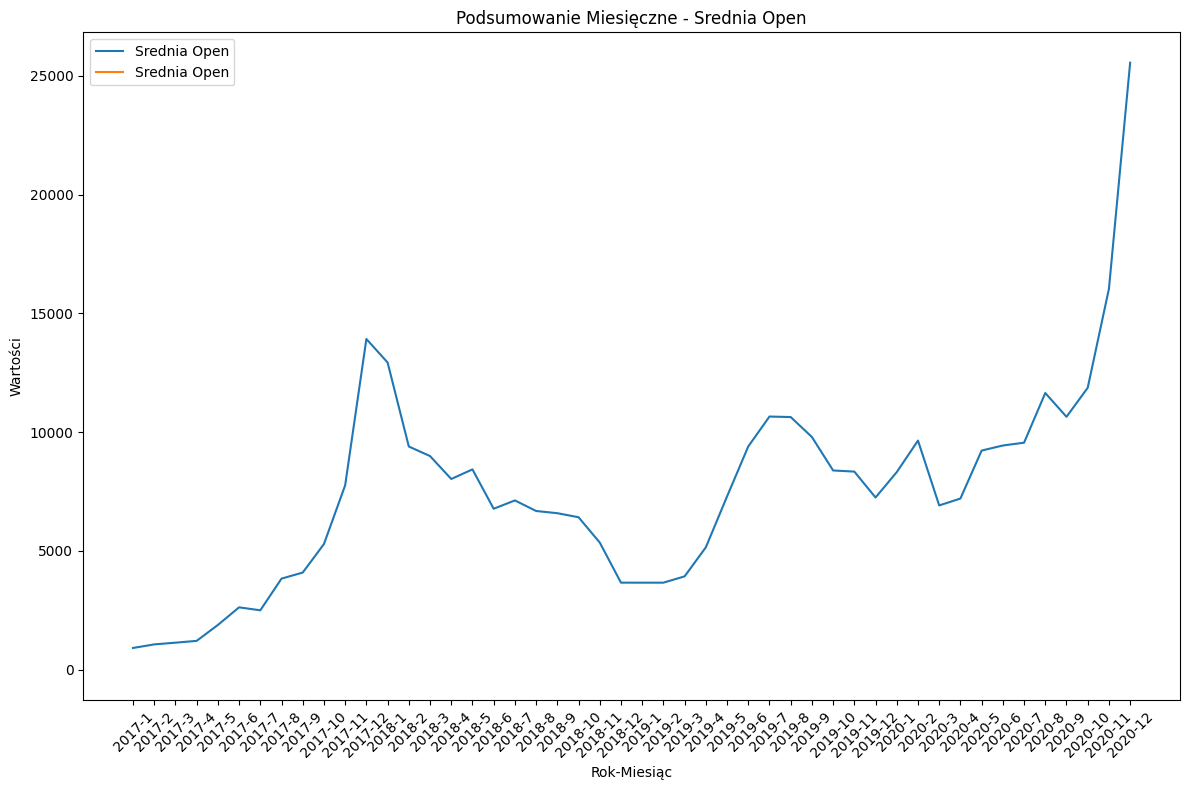

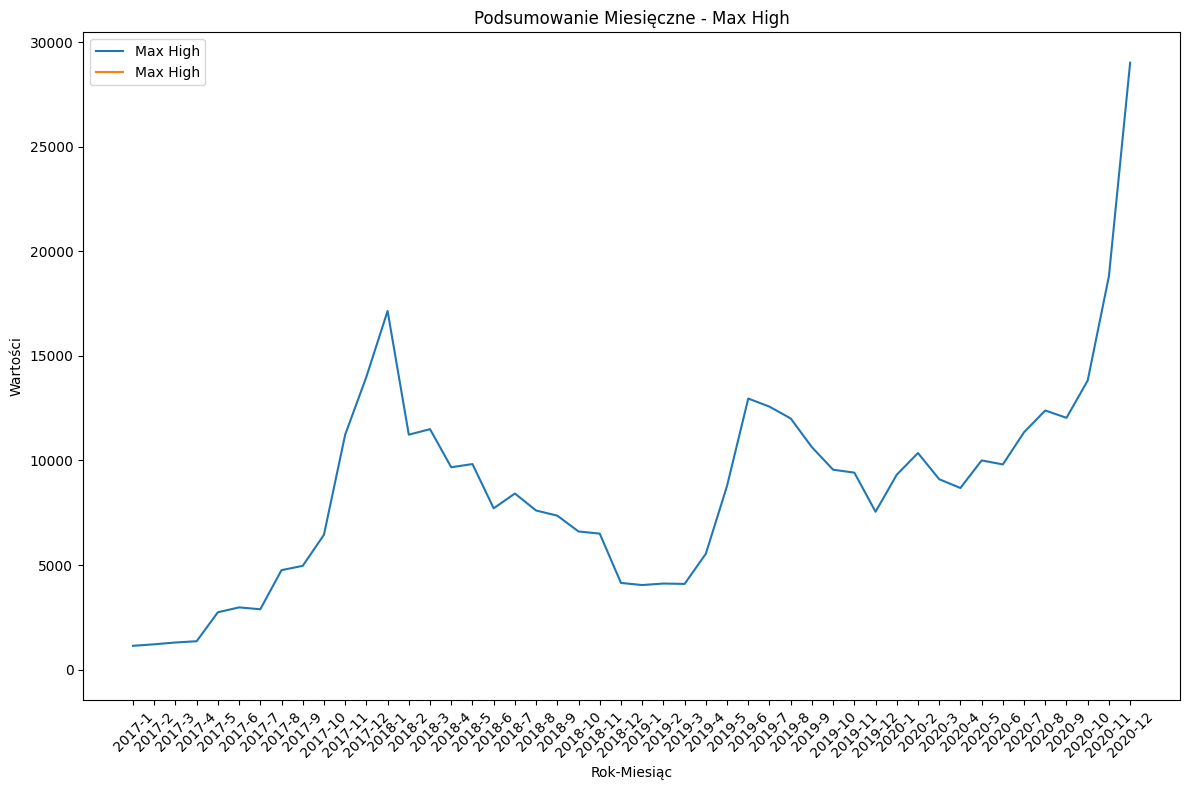

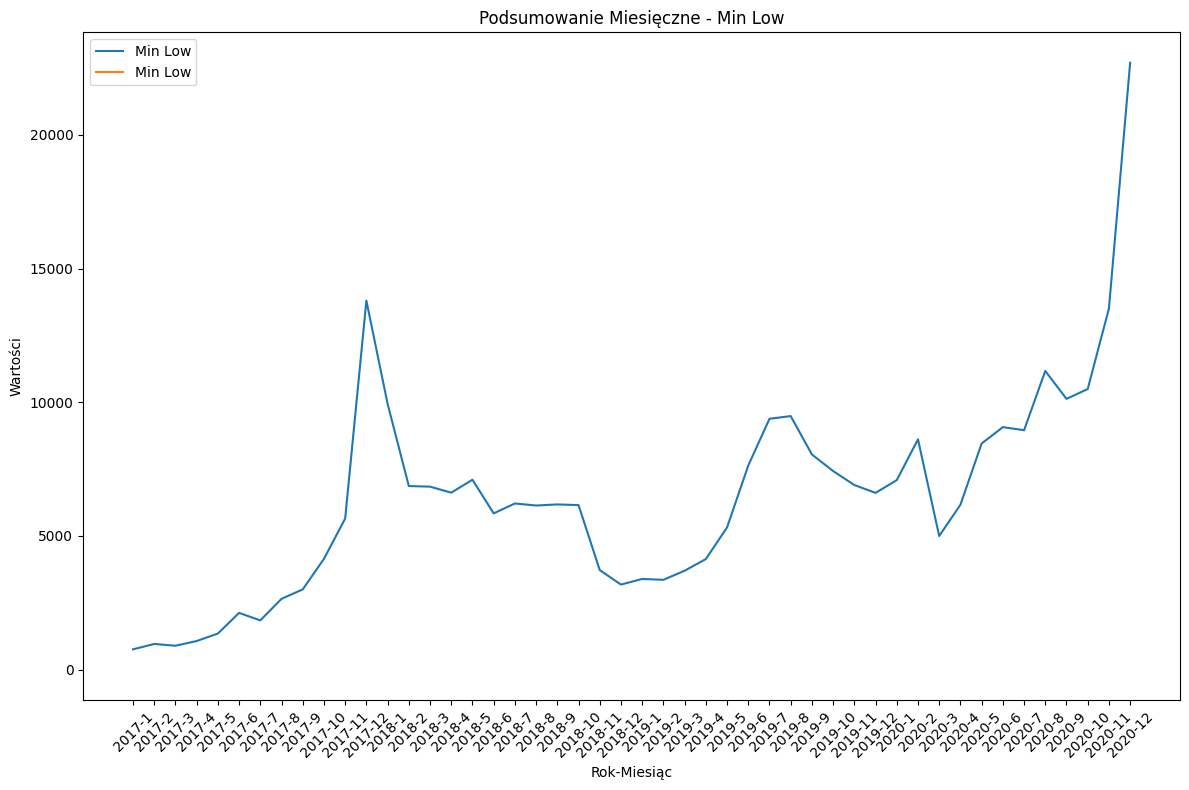

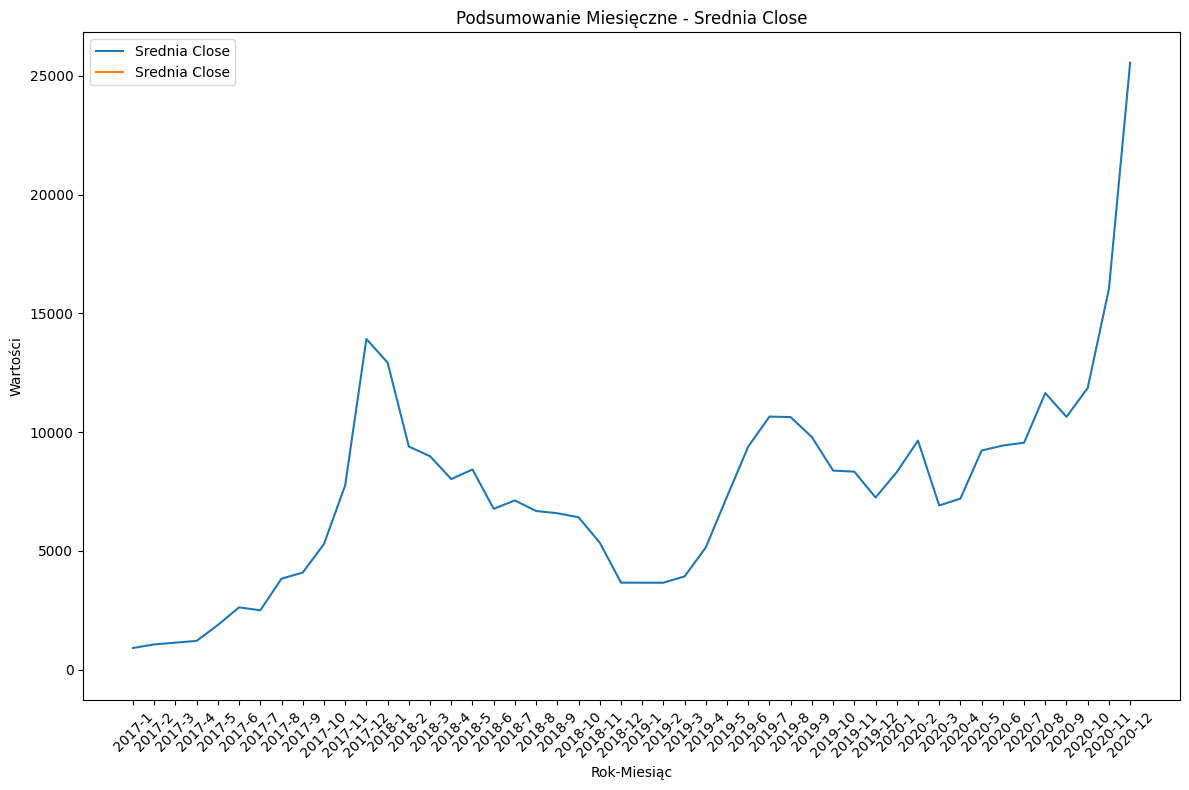

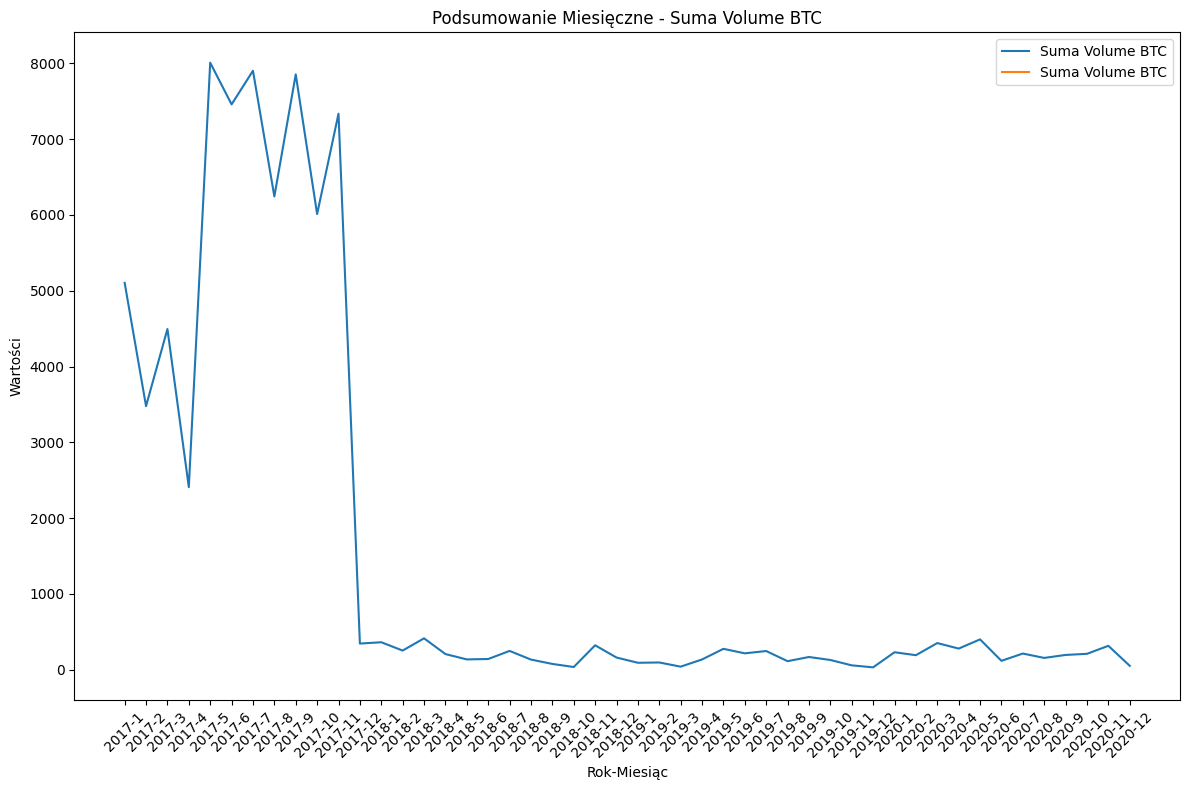

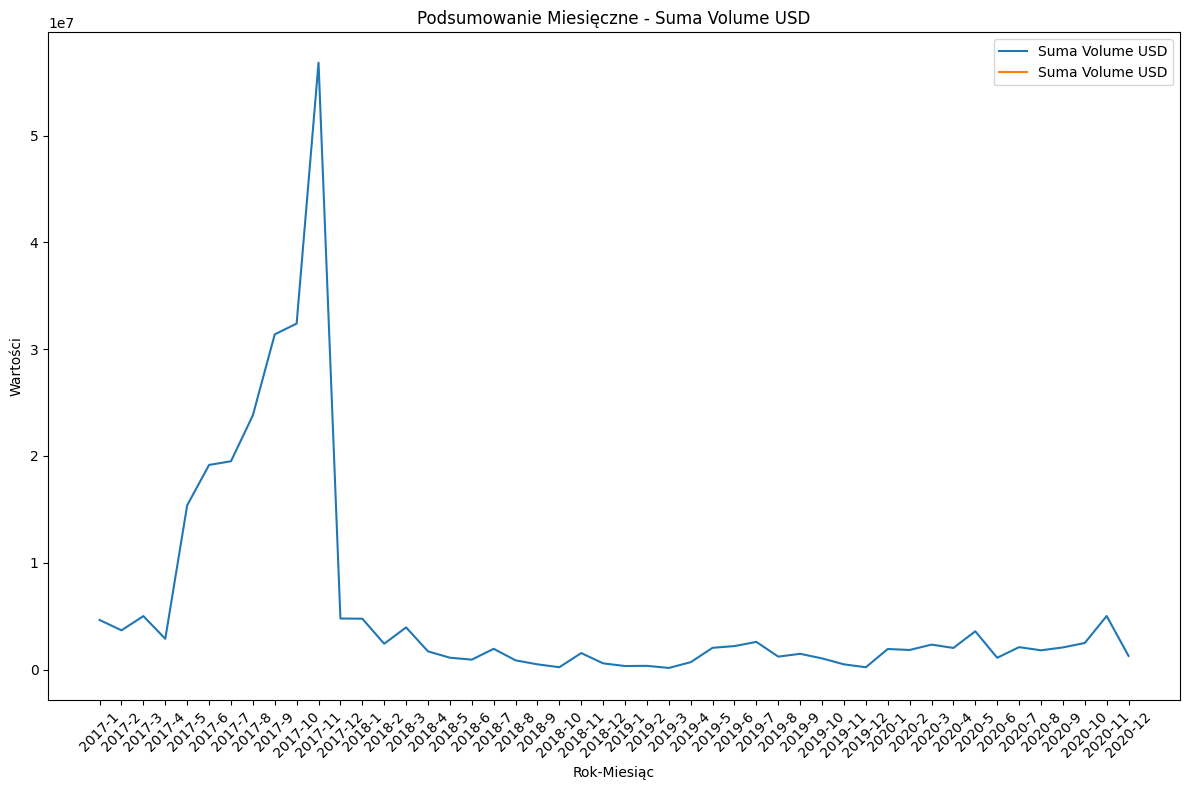

In [8]:
import numpy as np
import matplotlib.pyplot as plt

try:
    cursor = cnn.cursor()

    # Pobieranie danych z tabeli podsumowanie_miesieczne
    cursor.execute("SELECT rok, miesiac, srednia_open, max_high, min_low, srednia_close, suma_volume_btc, suma_volume_usd FROM podsumowanie_miesieczne ORDER BY rok, miesiac")
    result = cursor.fetchall()

    # Wyświetlenie nazw kolumn
    rok_miesiac = [f"{row[0]}-{row[1]}" for row in result]
    srednia_open = [row[2] for row in result]
    max_high = [row[3] for row in result]
    min_low = [row[4] for row in result]
    srednia_close = [row[5] for row in result]
    suma_volume_btc = [row[6] for row in result]
    suma_volume_usd = [row[7] for row in result]

    # Tworzenie osobnych wykresów dla każdej zmiennej
    variables = {'Srednia Open': srednia_open,
                 'Max High': max_high,
                 'Min Low': min_low,
                 'Srednia Close': srednia_close,
                 'Suma Volume BTC': suma_volume_btc,
                 'Suma Volume USD': suma_volume_usd}

    for variable_name, variable_data in variables.items():
        fig, ax = plt.subplots(figsize=(12, 8))
        index = np.arange(len(rok_miesiac))
        bar_width = 0.4

        plt.plot(index, variable_data, bar_width, label=variable_name)

        plt.xlabel('Rok-Miesiąc')
        plt.ylabel('Wartości')
        plt.title(f'Podsumowanie Miesięczne - {variable_name}')
        plt.xticks(index, rok_miesiac, rotation=45)
        plt.legend()

        plt.tight_layout()
        plt.show()

finally:
    cursor.close()